In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/main-duoka/main-duoka.py
/kaggle/input/indian-pines/Indian_pines_corrected.mat
/kaggle/input/indian-pines/Indian_pines_gt.mat


## 导入库

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import spectral
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time 

## 创建 HybridSN 类

In [40]:
class HybridSN(nn.Module):
    def __init__(self, num_classes=16):
        super(HybridSN, self).__init__()
        # 第一层三维卷积：Conv3d_1, Input:(1, 30, 25, 25), 8 个 7 × 3 × 3 的卷积核
        # Output: (8, 24, 23, 23)
        self.conv1 = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=(7, 3, 3), stride=1, padding=0),
            nn.ReLU(inplace=True) # 使用 inplace=True 的好处是不用开辟新的内存空间
        )

        # 第二层三维卷积：Conv3d_2，Input:(8, 24, 23, 23)，16 个 5 × 3 × 3 的卷积核
        # Output: (16, 20, 21, 21)
        self.conv2 = nn.Sequential(
            nn.Conv3d(8, 16, kernel_size=(5, 3, 3), stride=1, padding=0),
            nn.ReLU(inplace=True)
        )

        # 第三层三维卷积：Conv3d_3, Input(16, 20, 21, 21)，32 个 3 × 3 × 3 的卷积核
        # Output: (32, 18, 19, 19)
        self.conv3 = nn.Sequential(
            nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=1, padding=0),
            nn.ReLU(inplace=True)
        )

        # 第四层是二维卷积，但是要二维卷积之前就要把第三层的输出 reshape 成可以二维卷积的形状
        # 其实就是样本数和维度数堆叠：32 × 18 = 576，所以这一层二维卷积的输入为 576
        # Output: (64, 17, 17)
        self.conv4_2d = nn.Sequential(
            nn.Conv2d(576, 64, kernel_size=(3, 3), stride=1, padding=0),
            nn.ReLU(inplace=True)
        )

        # 二维卷积层之后就是一个全连接层，而在送入这个全连接层之前，要把二维卷积之后的输出降为一维才能送入全连接层
        # 所以在 forward 里直接使用 flatten()，那么输入全连接层参数即为：64 × 17 × 17 = 18496
        # 这一全连接层有 256 个节点
        self.dense1 = nn.Linear(18496, 256)

        # 接着又是一个全连接层，有 128 个节点
        self.dense2 = nn.Linear(256, 128)

        # 最终输出层，有 num_classes 这么多节点，因为我们最后就是要分 num_classes 这么多地物类别（Indian Pines）数据集
        self.dense_out = nn.Linear(128, num_classes)

        # 论文中使用了 Dropout ，参数为 0.4
        self.dropout = nn.Dropout(0.4)

    # 定义前向传播函数
    def forward(self, x):
        out = self.conv1(x)  # 第一层三维卷积
        out = self.conv2(out)  # 第二层三维卷积
        out = self.conv3(out)  # 第三层三维卷积 # 32, 18, 19, 19

        out = self.conv4_2d(out.reshape(out.shape[0], -1, 19, 19))  # 第四层二维卷积
        out = out.reshape(out.shape[0], -1)
        out = F.relu(self.dropout(self.dense1(out)))
        out = F.relu(self.dropout(self.dense2(out)))
        out = self.dense_out(out)
        return out

## 测试网络是否通

In [41]:
# 可以测试一下 HybridSN 通不通
# 我们最后输入到网络是小立方体，小立方体的输入格式是(batch_size, frames, height, width, channels)
# （三维卷积的输入和输出形状都是五维张量）
# 因为使用的是 Indian Pines，所以最后地物类别是 16 类

x = torch.randn(1, 1, 30, 25, 25)
net = HybridSN() # 实例化 HybridSN
print(net) # 看看 HybridSN 的实际网络
y = net(x) # 将 随机生成的五维张量 x 输入到 HybridSN 中查看输出结果的形状
print(y.shape)

HybridSN(
  (conv1): Sequential(
    (0): Conv3d(1, 8, kernel_size=(7, 3, 3), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv3d(8, 16, kernel_size=(5, 3, 3), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
  )
  (conv3): Sequential(
    (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (1): ReLU(inplace=True)
  )
  (conv4_2d): Sequential(
    (0): Conv2d(576, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
  )
  (dense1): Linear(in_features=18496, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=128, bias=True)
  (dense_out): Linear(in_features=128, out_features=16, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)
torch.Size([1, 16])


## 定义预处理相关函数

In [42]:
# 对高光谱数据集 X 应用 PCA 变换
def applyPCA(X, num_components):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=num_components, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], num_components))
    return newX


# 对单个像素周围提取 patch 时，边缘像素就无法取了，因此，给这部分像素进行 padding 操作
# 经过 padWithZeros 之后，宽、高会变成 169,169， 也就是左右各 padding 了 12
def padWithZeros(X, margin=12):
    # print(X)
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2 * margin, X.shape[2]))
    # print(newX.shape)  # (169, 169, 30) 全是 0
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX


#  对单个像素周围提取 patch 时，边缘像素就无法取了，因此，给这部分像素进行 padding 操作
def createImageCubes(X, y, windowSize=5, removeZeroLabels=True):
    # 给 X 做 padding
    margin = int((windowSize - 1) / 2)  # 12
    zeroPaddedX = padWithZeros(X, margin=margin)  # (169, 30, 30)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    # print(patchesData.shape) # (21025, 25, 25, 200)
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    # print(patchesLabels.shape) # (21025, )
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):  # for r in range(12, 169-12)
        for c in range(margin, zeroPaddedX.shape[1] - margin):  # for c in range(12, 169-12)
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            # print(patch.shape)
            # zeroPaddedX[r - 12 : r + 12 + 1, c -12 : c + 12 + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r - margin, c - margin]
            patchIndex = patchIndex + 1
    # 如果没有 removeZeroLabels
    # patchesData 的 shape 将会是 (21025, 25, 25, 30)
    # patchesLabels 的 shape 将会是 (21025, )
    # removeZeroLabels 的作用就是去掉 gt 标签集 groundtruth 中为 0 的数据，因为里面的数据值有 0~16，而刚好 1~16 刚好对应地物分类的 16 类
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels > 0, :, :, :]
        patchesLabels = patchesLabels[patchesLabels > 0]
        patchesLabels -= 1
    return patchesData, patchesLabels


# 随机划分训练集和测试集
# 这里最后取 testradio=0.9 也就是随机抽 90% 为测试集，10% 为训练集
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test

## 读取数据集，创建训练集和测试集类

In [43]:
# 读取数据集（使用 Indian Pines 数据集）
X = sio.loadmat('/kaggle/input/indian-pines/Indian_pines_corrected')['indian_pines_corrected']
y = sio.loadmat('/kaggle/input/indian-pines/Indian_pines_gt.mat')['indian_pines_gt']

# 用于测试样本的比例
test_ratio = 0.90
# 每个像素周围提取 patch 的尺寸
patch_size = 25
# 使用 PCA 降维，得到主成分的数量
pca_components = 30

print('Hyperspectral data shape: ', X.shape)
print('Label shape: ', y.shape)

print('\n... ... PCA tranformation ... ...')
X_pca = applyPCA(X, num_components=pca_components)
print('Data shape after PCA: ', X_pca.shape)

print('\n... ... create data cubes ... ...')
X_pca, y = createImageCubes(X_pca, y, windowSize=patch_size)
print('Data cube X shape: ', X_pca.shape)
print('Data cube y shape: ', y.shape)

print('\n... ... create train & test data ... ...')
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X_pca, y, test_ratio)
print('Xtrain shape: ', Xtrain.shape)
print('Xtest  shape: ', Xtest.shape)

# 改变 Xtrain, Ytrain 的形状，以符合 keras 的要求
Xtrain = Xtrain.reshape(-1, patch_size, patch_size, pca_components, 1)
Xtest  = Xtest.reshape(-1, patch_size, patch_size, pca_components, 1)
print('before transpose: Xtrain shape: ', Xtrain.shape) 
print('before transpose: Xtest  shape: ', Xtest.shape) 

# 为了适应 pytorch 结构，数据要做 transpose
Xtrain = Xtrain.transpose(0, 4, 3, 1, 2)
Xtest  = Xtest.transpose(0, 4, 3, 1, 2)
print('after transpose: Xtrain shape: ', Xtrain.shape) 
print('after transpose: Xtest  shape: ', Xtest.shape) 


""" Training dataset"""
class TrainDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtrain.shape[0]
        self.x_data = torch.FloatTensor(Xtrain)
        self.y_data = torch.LongTensor(ytrain)        
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

""" Testing dataset"""
class TestDS(torch.utils.data.Dataset): 
    def __init__(self):
        self.len = Xtest.shape[0]
        self.x_data = torch.FloatTensor(Xtest)
        self.y_data = torch.LongTensor(ytest)
    def __getitem__(self, index):
        # 根据索引返回数据和对应的标签
        return self.x_data[index], self.y_data[index]
    def __len__(self): 
        # 返回文件数据的数目
        return self.len

# 创建 trainloader 和 testloader
trainset = TrainDS()
testset  = TestDS()
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=128, shuffle=True, num_workers=2)
test_loader  = torch.utils.data.DataLoader(dataset=testset,  batch_size=128, shuffle=False, num_workers=2)

Hyperspectral data shape:  (145, 145, 200)
Label shape:  (145, 145)

... ... PCA tranformation ... ...
Data shape after PCA:  (145, 145, 30)

... ... create data cubes ... ...
Data cube X shape:  (10249, 25, 25, 30)
Data cube y shape:  (10249,)

... ... create train & test data ... ...
Xtrain shape:  (1024, 25, 25, 30)
Xtest  shape:  (9225, 25, 25, 30)
before transpose: Xtrain shape:  (1024, 25, 25, 30, 1)
before transpose: Xtest  shape:  (9225, 25, 25, 30, 1)
after transpose: Xtrain shape:  (1024, 1, 30, 25, 25)
after transpose: Xtest  shape:  (9225, 1, 30, 25, 25)


## 检测 `cuda` 可用性和多卡信息

In [44]:
# 查看 cuda 是否可用，可用情况下打印可用 GPU(s) 相关信息
if torch.cuda.is_available():
    gpus = []
    print(f"Found {torch.cuda.device_count()} GPUs available ✔")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        gpus.append(i)
        # nn.DataParallel 多卡汇总，用于汇总多个GPU的计算结果并输出模型的训练过程和性能指标，通常拿第一张卡
        output_device = gpus[0]
    print(f'GPUS_ID: {gpus}')
    print(f'OUTPUT_GPU_ID: {output_device}')
else:
    print("No GPUs found")

Found 2 GPUs available ✔
GPU 0: Tesla T4
GPU 1: Tesla T4
GPUS_ID: [0, 1]
OUTPUT_GPU_ID: 0


## 开始使用多卡训练

In [45]:
model = HybridSN()
model = nn.DataParallel(model.cuda(), device_ids=gpus, output_device=gpus[0])
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 开始训练
s_time = time.time()
total_loss = 0
total_step = 100
for epoch in range(100):
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.cuda()
        labels = labels.cuda()
        # 优化器梯度归零
        optimizer.zero_grad()
        # 正向传播 +　反向传播 + 优化 
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print('[Epoch: %d]   [loss avg: %.4f]   [current loss: %.4f]' %(epoch + 1, total_loss/(epoch+1), loss.item()))
e_time = time.time()
train_time = e_time - s_time
print(f"Training time: {train_time}")
print('Finished Training')
# 判断是否使用了多 GPU 进行训练
if torch.cuda.device_count() > 1 and len(model.device_ids) > 1:
    print('This code is trained on multiple GPUs.')
else:
    print('This code is not trained on multiple GPUs.')

[Epoch: 1]   [loss avg: 22.0902]   [current loss: 2.7489]
[Epoch: 2]   [loss avg: 21.7627]   [current loss: 2.5258]
[Epoch: 3]   [loss avg: 21.1223]   [current loss: 2.3162]
[Epoch: 4]   [loss avg: 20.6416]   [current loss: 2.3892]
[Epoch: 5]   [loss avg: 20.3045]   [current loss: 2.3865]
[Epoch: 6]   [loss avg: 20.0434]   [current loss: 2.2983]
[Epoch: 7]   [loss avg: 19.7723]   [current loss: 2.2865]
[Epoch: 8]   [loss avg: 19.4895]   [current loss: 2.1331]
[Epoch: 9]   [loss avg: 19.2160]   [current loss: 2.1250]
[Epoch: 10]   [loss avg: 18.9412]   [current loss: 2.0925]
[Epoch: 11]   [loss avg: 18.6075]   [current loss: 1.7648]
[Epoch: 12]   [loss avg: 18.2093]   [current loss: 1.7601]
[Epoch: 13]   [loss avg: 17.7210]   [current loss: 1.4109]
[Epoch: 14]   [loss avg: 17.1857]   [current loss: 1.0317]
[Epoch: 15]   [loss avg: 16.5975]   [current loss: 0.9148]
[Epoch: 16]   [loss avg: 15.9904]   [current loss: 0.7248]
[Epoch: 17]   [loss avg: 15.3943]   [current loss: 0.6663]
[Epoch

## 模型测试，打印分类准确度等信息

In [46]:
count = 0
model = model.eval()
# 模型测试
for inputs, _ in test_loader:
    inputs = inputs.cuda()
    outputs = model(inputs)
    outputs = np.argmax(outputs.detach().cpu().numpy(), axis=1)
    if count == 0:
        y_pred_test =  outputs
        count = 1
    else:
        y_pred_test = np.concatenate( (y_pred_test, outputs) )

# 生成分类报告
classification = classification_report(ytest, y_pred_test, digits=4)
print(classification)

              precision    recall  f1-score   support

         0.0     1.0000    0.8780    0.9351        41
         1.0     0.9910    0.9385    0.9640      1285
         2.0     0.9802    0.9933    0.9867       747
         3.0     0.9900    0.9343    0.9614       213
         4.0     0.9596    0.9816    0.9705       435
         5.0     0.9774    0.9878    0.9826       657
         6.0     1.0000    0.8800    0.9362        25
         7.0     0.9815    0.9860    0.9838       430
         8.0     1.0000    1.0000    1.0000        18
         9.0     0.9729    0.9840    0.9784       875
        10.0     0.9682    0.9787    0.9734      2210
        11.0     0.9829    0.9663    0.9745       534
        12.0     1.0000    0.9459    0.9722       185
        13.0     0.9735    0.9991    0.9861      1139
        14.0     0.9553    0.9856    0.9702       347
        15.0     0.9195    0.9524    0.9357        84

    accuracy                         0.9754      9225
   macro avg     0.9782   

## 可视化分类结果

... ... row  0  handling ... ...
... ... row  20  handling ... ...
... ... row  40  handling ... ...
... ... row  60  handling ... ...
... ... row  80  handling ... ...
... ... row  100  handling ... ...
... ... row  120  handling ... ...
... ... row  140  handling ... ...


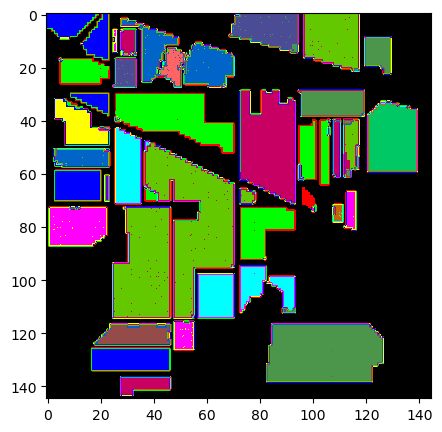

In [47]:
## 显示分类结果
# load the original image
X = sio.loadmat('/kaggle/input/indian-pines/Indian_pines_corrected')['indian_pines_corrected']
y = sio.loadmat('/kaggle/input/indian-pines/Indian_pines_gt.mat')['indian_pines_gt']

height = y.shape[0]
width = y.shape[1]

X = applyPCA(X, num_components = pca_components)
X = padWithZeros(X, patch_size//2)

# 逐像素预测类别
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        if int(y[i,j]) == 0:
            continue
        else :
            image_patch = X[i:i+patch_size, j:j+patch_size, :]
            image_patch = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1)
            X_test_image = torch.FloatTensor(image_patch.transpose(0, 4, 3, 1, 2)).cuda()                                 
            prediction = model(X_test_image)
            prediction = np.argmax(prediction.detach().cpu().numpy(), axis=1)
            outputs[i][j] = prediction+1
    if i % 20 == 0:
        print('... ... row ', i, ' handling ... ...')
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(5,5)) # 查看结果